In [1]:
# Load the Pandas libraries with alias 'pd' 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
def readDektakFile(fileName):
    # Read data from file 'filename.csv' 
    # (in the same directory that your python process is based)
    # Control delimiters, rows, column names with read_csv (see later) 
    data = pd.read_csv(fileName, skiprows=22) 
    # Preview the first 5 lines of the loaded data 
    data = data.drop(data.columns[2], axis=1)
    data = data.drop(data.columns[2], axis=1)
    data.head()
    height = np.swapaxes(data.to_numpy(), 0, 1)
    return height[0], height[1]

In [7]:
confocal = {
    2*60:   [0.4,0.46,0.4],
    1*60:   [0.17,0.16,0.17,0.16,0.17,0.16,0.17,0.17],
    2*60+30:[0.54,0.53,0.49,0.48,0.49],
    3*60:   [0.61,0.61,0.61,0.6],
    30:     [0.07,0.08,0.08,0.08,0.08],
    90:     [0.33,0.31,0.31,0.28]
}

In [3]:
def stepSize(x,z, ths):
    plt.figure()
    plt.plot(x, z)
    threshold_h = max(z)*ths[0]
    threshold_l = max(z)*ths[1]
    plt.hlines([threshold_h, threshold_l], 0, 400)

    erosion = 200
    mask_h = z>threshold_h
    mask_h_eroded = mask_h.copy()
    for i, m in enumerate(mask_h):
        if not m:
            mask_h_eroded[max(0,i-erosion):min(i+erosion+1, len(mask_h))] = np.full(min(i+erosion+1, len(mask_h))-max(0,i-erosion), False)

    mask_l = z<threshold_l
    mask_l_eroded = mask_l.copy()
    for i, m in enumerate(mask_l):
        if not m:
            mask_l_eroded[max(0,i-erosion):min(i+erosion+1, len(mask_l))] = np.full(min(i+erosion+1, len(mask_l))-max(0,i-erosion), False)

    x_h = x[mask_h_eroded]
    z_h = z[mask_h_eroded]
    plt.scatter(x_h, z_h)
    x_l = x[mask_l_eroded]
    z_l = z[mask_l_eroded]
    plt.scatter(x_l, z_l)

    fit_h, r_h, _, _, _ = np.polyfit(x_h, z_h, 1, full=True)
    p_h = np.poly1d(fit_h)
    plt.plot(x_h, p_h(x_h))

    fit_l, r_l, _, _, _ = np.polyfit(x_l, z_l, 1, full=True)
    p_l = np.poly1d(fit_l)
    plt.plot(x_l, p_l(x_l))

    var = np.sqrt(np.var(z_h)**2 + np.var(z_l)**2)
    

    m = (max(x)+min(x))/2
    m_h = p_h(m)
    m_l = p_l(m)
    plt.vlines(m,m_l, m_h, color="red")
    return m_h-m_l, np.sqrt((r_h[0]/len(x_h))+(r_l[0]/len(x_l)))
    



120  :  etch_data/group1/v2 2min SF6O2 plasma bulk Si.csv
60  :  etch_data/group1/v3 1min SF6O2 plasma bulk Si.csv
30  :  etch_data/group2/30s SF6O2 etch bulk Si sample3.csv
90  :  etch_data/group2/90s SF6O2 etch bulk Si sample3.csv
15  :  etch_data/group3/0-15-etch.csv
150  :  etch_data/group3/2-30-etch.csv
180  :  etch_data/group3/3-00-etch.csv


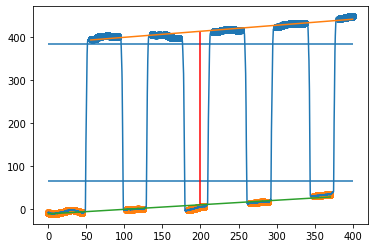

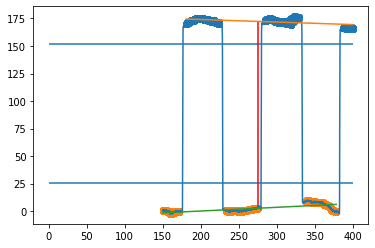

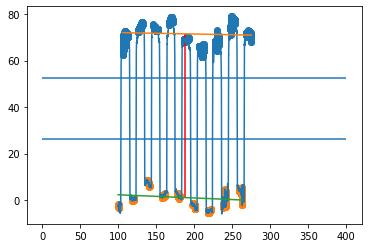

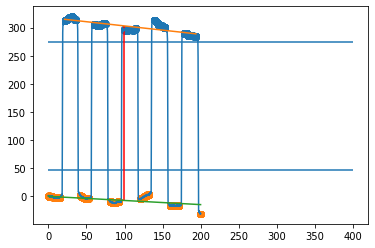

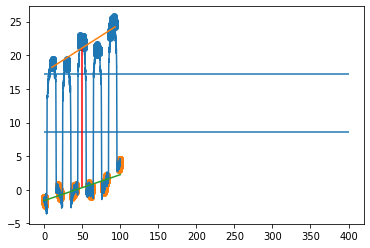

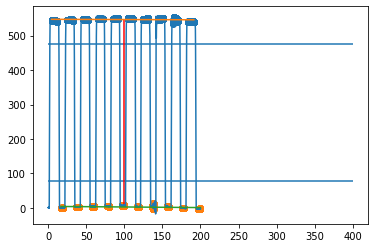

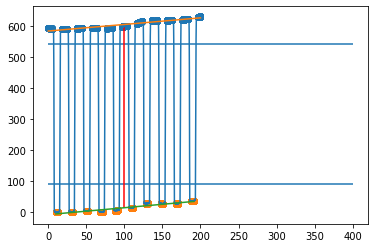

In [4]:
files={
    2*60:   "etch_data/group1/v2 2min SF6O2 plasma bulk Si.csv",
    1*60:   "etch_data/group1/v3 1min SF6O2 plasma bulk Si.csv",
    30:     "etch_data/group2/30s SF6O2 etch bulk Si sample3.csv",
    90:     "etch_data/group2/90s SF6O2 etch bulk Si sample3.csv",
    15:     "etch_data/group3/0-15-etch.csv",
    2*60+30:"etch_data/group3/2-30-etch.csv",
    3*60:   "etch_data/group3/3-00-etch.csv"
}

cuts = {
    30: (100,275),
    60: (150,400),
}

thresh = {
    15: (2/3, 1/3),
    30: (2/3, 1/3)
}

steps = []
var_s = []
durs = []
for dur in files:
    file = files[dur]
    print(dur, " : ", file)
    ths = (6/7, 1/7)
    if dur in thresh:
        ths = thresh[dur]
    x,z = readDektakFile(file)
    if dur in cuts:
        interval = cuts[dur]
        cut = np.logical_and(x>interval[0],x<interval[1])
        z = z[cut]
        x = x[cut]
    step, var = stepSize(x,z,ths)
    steps.append(step)
    var_s.append(var)
    durs.append(dur)

thus etching 85 nm deep requires 23.616s


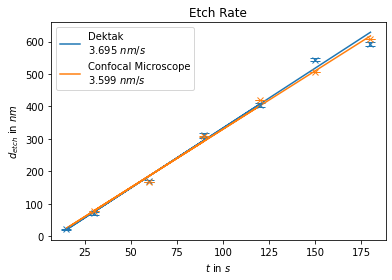

In [8]:
fit_er = np.polyfit(durs, steps, 1, w=1/np.array(var_s))
p_er = np.poly1d(fit_er)
plt.plot(durs, p_er(durs), color="C0", label="Dektak\n{} $nm/s$".format(round(fit_er[0],3)))
plt.errorbar(durs, steps, yerr=var_s, fmt='x', capsize=5, color="C0")

confocal_steps = []
confocal_durs = []
confocal_vars = []
for conf_dur in confocal:
    confocal_durs.append(conf_dur)
    confocal_steps.append(np.mean(confocal[conf_dur])*1000)
    confocal_vars.append(np.var(confocal[conf_dur])*1000)

fit_er = np.polyfit(confocal_durs, confocal_steps, 1)
p_er = np.poly1d(fit_er)
plt.plot(durs, p_er(durs),color="C1", label="Confocal Microscope\n{} $nm/s$".format(round(fit_er[0],3)))
plt.errorbar(confocal_durs, confocal_steps, yerr=confocal_vars, fmt='x', capsize=5, color="C1")

plt.legend()

plt.xlabel("$t$ in $s$")
plt.ylabel("$d_{etch}$ in $nm$")
plt.title("Etch Rate")
print("thus etching 85 nm deep requires {}s".format(round(85/fit_er[0],3)))